In [2]:
from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

import scipy.spatial.distance as dist
import scipy.stats as stats

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

### extract features using vgg19 

In [62]:
def deactivate(net):
    net.eval()
    for p in net.parameters():
        p.requires_grad = False       
 
       
use_cuda = torch.cuda.is_available()
cuda_device = 3

vgg19 = models.vgg19(pretrained=True).cuda(cuda_device)

conv1 = nn.Sequential(*(list(vgg19.features.children())[slice(0, 5)]))
conv2 = nn.Sequential(*(list(vgg19.features.children())[slice(5, 10)]))
conv3 = nn.Sequential(*(list(vgg19.features.children())[slice(10, 19)]))
conv4 = nn.Sequential(*(list(vgg19.features.children())[slice(19, 28)]))
conv5 = nn.Sequential(*(list(vgg19.features.children())[slice(28, 37)]))
fc6 = nn.Sequential(*(list(vgg19.classifier.children())[slice(0, 2)]))
fc7 = nn.Sequential(*(list(vgg19.classifier.children())[slice(3, 5)]))
fc8 = nn.Sequential(list(vgg19.classifier.children())[-1])

if use_cuda:
    conv1.cuda(cuda_device)
    conv2.cuda(cuda_device)
    conv3.cuda(cuda_device)
    conv4.cuda(cuda_device)
    conv5.cuda(cuda_device)
    fc6.cuda(cuda_device)    
    fc7.cuda(cuda_device)    
    fc8.cuda(cuda_device)        
        
deactivate(conv1)
deactivate(conv2)
deactivate(conv3)
deactivate(conv4)
deactivate(conv5)
deactivate(fc6)
deactivate(fc7)
deactivate(fc8)

### get sketch data and metadata

In [3]:
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result


def list_classes(path):
    classes = [y.split('/')[-1] for x in os.walk(sketch_dir) \
                      for y in glob(os.path.join(x[0])) \
                      if y.split('/')[-1] !='sketches']    
    return classes

def get_class_from_path(path):
    return path.split('/')[-2]

sketch_dir = '/home/jefan/full_sketchy_dataset/sketches'
photo_dir = '/home/jefan/full_sketchy_dataset/photos'

sketch_paths = list_files(sketch_dir, ext='png') 
photo_paths = list_files(photo_dir, ext='jpg') 

sketch_classes = [s.split('/')[-2] for s in sketch_paths]
photo_classes = [p.split('/')[-2] for p in photo_paths]

# organize into dataframe
S = pd.DataFrame([sketch_classes,sketch_paths])
S = S.transpose()
S.columns = ['class','path']

P = pd.DataFrame([photo_classes,photo_paths])
P = P.transpose()
P.columns = ['class','path']

print 'Number of sketches: ' + str(len(sketch_paths))
print 'Number of photos: ' + str(len(photo_paths))
num_photos = len(photo_paths)
num_sketches = len(sketch_paths)

Number of sketches: 75481
Number of photos: 12500


In [64]:
def load_image(path, imsize=224, volatile=True, use_cuda=False):
    im = Image.open(path)
    im = im.convert('RGB')

    loader = transforms.Compose([
        transforms.Scale(imsize),
        transforms.ToTensor()])

    im = Variable(loader(im), volatile=volatile)
    im = im.unsqueeze(0)
    if use_cuda:
        im = im.cuda(cuda_device)
    return im

def image_generator(paths, imsize=224, use_cuda=use_cuda):
    for path in paths:
        image = load_image(path)
        label = get_class_from_path(path)
        yield (image, label)


In [65]:
def _flatten(x):
    return x.view(x.size(0), -1)
   
def extract_layer(x, layer_index):
    x_conv1 = conv1(x)
    if layer_index == 0:
        return _flatten(x_conv1)
    x_conv2 = conv2(x_conv1)
    if layer_index == 1:
        return _flatten(x_conv2)
    x_conv3 = conv3(x_conv2)
    if layer_index == 2:
        return _flatten(x_conv3)
    x_conv4 = conv4(x_conv3)
    if layer_index == 3:
        return _flatten(x_conv4)
    x_conv5 = conv5(x_conv4)
    x_conv5_flat = _flatten(x_conv5)
    if layer_index == 4:
        return x_conv5_flat
    x_fc6 = fc6(x_conv5_flat)
    if layer_index == 5:
        return x_fc6
    x_fc7 = fc7(x_fc6)
    if layer_index == 6:
        return x_fc7
    x_fc8 = fc8(x_fc7)
    if layer_index == 7:
        return x_fc8
    
def extract_features_and_classes(domain, num_images, layer_index):

    generator = image_generator(domain,imsize=224,use_cuda=use_cuda)
    # initialize image and label matrices
    Features = []
    Labels = []
    n = 0
    quit = False 

    # generate batches of imagees and labels    
    if generator:
        while True:    
            batch_size = 64
            image_batch = Variable(torch.zeros(batch_size, 3, 224, 224))
            if use_cuda:
                image_batch = image_batch.cuda(cuda_device)                
            label_batch = []   
            if n%10==0:
                print('Batch {}'.format(n + 1))            
            for b in range(batch_size):
                try:
                    image, label = generator.next()
                    image_batch[b] = image   
                    label_batch.append(label)
                except StopIteration:
                    quit = True
                    print 'stopped!'
                    break                
                
            if n == num_images//batch_size:
                image_batch = image_batch.narrow(0,0,b)
                label_batch = label_batch[:b + 1] 
            n = n + 1       

            # extract features from batch
            image_batch = extract_layer(image_batch, layer_index)                        
            image_batch = image_batch.cpu().data.numpy()

            if len(Features)==0:
                Features = image_batch
            else:
                Features = np.vstack((Features,image_batch))
            Labels.append(label_batch)

            if n == num_images//batch_size + 1:
                break
    Labels = np.array([item for sublist in Labels for item in sublist])
    return Features, Labels

In [ ]:
# define layer you want to extract from and do so...
layer = 7
print('Extracting photo features...')
PF, PL = extract_features_and_classes(photo_paths, num_photos, layer)
print('Extracting sketch features...')
SF, SL = extract_features_and_classes(sketch_paths, num_sketches, layer)

Extracting photo features...
Batch 1
Batch 11
Batch 21
Batch 31
Batch 41
Batch 51
Batch 61
Batch 71
Batch 81
Batch 91
Batch 101
Batch 111
Batch 121
Batch 131
Batch 141
Batch 151
Batch 161
Batch 171
Batch 181
Batch 191
stopped!
Extracting sketch features...
Batch 1
Batch 11
Batch 21
Batch 31
Batch 41
Batch 51
Batch 61
Batch 71
Batch 81
Batch 91
Batch 101
Batch 111
Batch 121
Batch 131
Batch 141
Batch 151
Batch 161
Batch 171
Batch 181
Batch 191
Batch 201
Batch 211
Batch 221
Batch 231
Batch 241
Batch 251
Batch 261
Batch 271
Batch 281
Batch 291
Batch 301
Batch 311
Batch 321
Batch 331
Batch 341
Batch 421
Batch 431


In [41]:
## normalize and get means of feature vectors

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu


In [54]:
## save out features
inds = np.argsort(P['class'].values)
_PF = normalize(PF[inds])
_PL = PL[inds]

inds = np.argsort(S['class'].values)
_SF = normalize(SF[inds])
_SL = SL[inds]

def save_features(save_path,F,layer,domain):
    if domain=='photo':
        np.save(os.path.join(save_path,'photo_features_{}.npy'.format(layer)),F)
    elif domain=='sketch':
        np.save(os.path.join(save_path,'sketch_features_{}.npy'.format(layer)),F)

save_features('features',_PF,layer,'photo')      
save_features('features',_SF,layer,'sketch')      

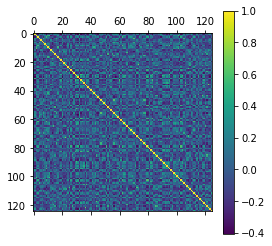

In [55]:
# plot photo similarity matrix
Pmeans = get_class_means(_PF, _PL)
PMAT = np.corrcoef(Pmeans)
plt.matshow(PMAT)
plt.colorbar()

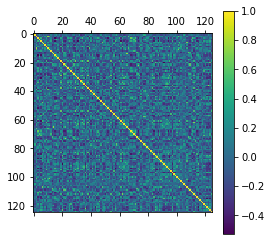

In [56]:
# plot sketch similarity matrix
Smeans = get_class_means(_SF, _SL)
SMAT = np.corrcoef(Smeans)
plt.matshow(SMAT)
plt.colorbar()

In [57]:
## compute cross-domain similarity
def get_rdm_similarity(a,b):
    '''
    "a" is one RDM made from, e.g., sketches
    "b" is another RDM made from, e.g., photos
    what is between-RDM similarity?
    '''    
    xdist = stats.pearsonr(dist.squareform(a, checks=False), dist.squareform(b, checks=False))    
    return xdist

r,p = get_rdm_similarity(PMAT,SMAT)
print r,p

0.48951072042 0.0


In [58]:
r,p = stats.spearmanr(PMAT.flatten(),SMAT.flatten())
print r,p

0.448521334147 0.0
